In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from ngallery_utils import DATASETS

import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import cm

import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cf

from distributed import Client
from ncar_jobqueue import NCARCluster



/glade/work/rneale/python/miniconda3/envs/notebook-gallery/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
cluster = NCARCluster()
cluster.scale(10)
client = Client(cluster)
client

/glade/work/rneale/python/miniconda3/envs/notebook-gallery/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35665 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/casper/proxy/35665/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/casper/proxy/35665/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.49:35540,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/casper/proxy/35665/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
# Global stuff
lon_min = -82. ; lon_max = -35.
lat_min = -15. ; lat_max = 15.

day0 = '2010-06-01'
day1 = '2010-06-30'

clon_min = 360.+lon_min
clon_max = 360.+lon_max


#cam_only = True ; pset = 'cam' ; nplots = 6 ; xfsize = 30 ; case = ['100 km','50 km','25 km','12 km','6 km','6 km+L71']
cam_only = False ; pset = 'obs-wrf-hov'; nplots = 3 ; xfsize = 18 ; case = ['iMERGE','TRMM','WRF(4km)']

#case = ['TRMM-25km','WRF-4km','CAM-SE-6km']
#case = ['IMERG-GPM-4km','WRF-4km','CAM-SE-6km']



##### LEVELS FOR PLOTTING #####

lev0 = 1 ; nlevs = 15
levels = [lev0 + 2*n for n in range(nlevs)]
dir

############ GLOBAL STUFF ###########


## WRF stuff
file_wrf = "/glade/scratch/rneale/SAAG/wrf2d_d01_daily_tot_201006.nc"
ds_wrf = xr.open_dataset(file_wrf)
da_time = ds_wrf['Times']

# CAM stuff (datasets pulled later)
#dir_cam = '/glade/scratch/patc/archive/'
dir_cam = '/glade/campaign/cgd/projects/NCGD0051/PRELIM_RESULTS/cesm2_2_rel/'

#file_cam = ['/glade/scratch/patc/archive/f.e22b6.DEFAULT.ne30x1.TUNE_02/atm/hist/f.e22b6.DEFAULT.ne30x1.TUNE_02.cam.h0.2010-06.nc',
file_cam =  ['f.e22b6.SAMwrf01.ne30x1.TUNE_02/atm/hist/f.e22b6.SAMwrf01.ne30x1.TUNE_02.cam.h0.2010-06.nc',
             'f.e22b6.SAMwrf01.ne30x2.TUNE_02/atm/hist/f.e22b6.SAMwrf01.ne30x2.TUNE_02.cam.h0.2010-06.nc',
            'f.e22b6.SAMwrf01.ne30x4.TUNE_02/atm/hist/f.e22b6.SAMwrf01.ne30x4.TUNE_02.cam.h0.2010-06.nc',
            'f.e22b6.SAMwrf01.ne30x8.TUNE_02/atm/hist/f.e22b6.SAMwrf01.ne30x8.TUNE_02.cam.h0.2010-06.nc',
            'f.e22b6.SAMwrf01.ne30x16.TUNE_01/atm/hist/f.e22b6.SAMwrf01.ne30x16.TUNE_01.cam.h0.2010-06.nc',
            'f.e22b6.SAMwrf01.ne30x16.L71-Opt5_TUNE_05/atm/hist/f.e22b6.SAMwrf01.ne30x16.L71-Opt5_TUNE_05.cam.h0.2010-06.nc']

#file_cam = ['f.e22b6.SAMwrf01.ne30x1.L71opt5_TUNE_02',
#            'f.e22b6.SAMwrf01.ne30x4.L71opt5_TUNE_02',
#            'f.e22b6.SAMwrf01.ne30x8.L71opt5_TUNE_02']
            



In [4]:
# Observations TRMM

print("Grabbing TRMM")
file_obs = '/glade/p/cgd/amp/rneale/data/TRMM/daily/3B42.2010.daily_V7.nc'
ds_obs =  xr.open_dataset(file_obs)

# Obsrevations iMERGE

print("Grabbing iMERGE")
dir_obs2 = '/glade/scratch/rneale/SAAG/obs/2010/06/*nc'
ds_obs2 = xr.open_mfdataset(dir_obs2, decode_cf=True, decode_times = True, parallel=True) 

print('done obs.')



ds_obs2.precipitationCal

Grabbing TRMM
Grabbing iMERGE
done obs.


<xarray.DataArray 'precipitationCal' (time: 1440, lat: 690, lon: 480)>
dask.array<concatenate, shape=(1440, 690, 480), dtype=float32, chunksize=(2, 690, 480), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -55.95 -55.85 -55.75 -55.65 ... 12.75 12.85 12.95
  * lon      (lon) float64 -81.95 -81.85 -81.75 -81.65 ... -34.25 -34.15 -34.05
  * time     (time) datetime64[ns] 2010-06-01 ... 2010-06-30T23:30:00.000026880
Attributes:
    long_name:  precipitationCal
    units:      mm/hr

# Handling WRF files to makes them xarray compatable

In [13]:
time_strs = [str(i.values)[1:] for i in da_time]
#time_strs
time_strs = [str(i.values)[1:].replace("_"," ") for i in da_time]
time_datetime = pd.to_datetime(time_strs)
ds_wrf_timedim = ds_wrf.rename({'Time':'time'})
ds_wrf_timecoord = ds_wrf_timedim.assign(time=time_datetime)
ds_wrf_dropped_Times = ds_wrf_timecoord.drop('Times')


ds_geo = xr.open_dataset("/glade/scratch/rneale/SAAG/wrfconstants_SAAG_20yr.nc")


ds_wrf_w_latlon = ds_wrf_dropped_Times.assign_coords(lat=ds_geo.coords['XLAT'].squeeze('Time'), lon=ds_geo.coords['XLONG'].squeeze('Time'))


ds_wrf_w_latlon = ds_wrf_dropped_Times.assign_coords(
        lat=ds_geo.coords['XLAT'].squeeze('Time'),
        lon=ds_geo.coords['XLONG'].squeeze('Time'),
        landmask=ds_geo.LANDMASK.squeeze('Time'),
        lakemask=ds_geo.LAKEMASK.squeeze('Time'))
ds_wrf_rename_latlon = ds_wrf_w_latlon.rename({'south_north':'y', 'west_east':'x'})
ds_wrf_dropxlatlon = ds_wrf_rename_latlon.drop(['XLAT', 'XLONG'])

#### WRF ####
ds_wrf_cf = ds_wrf_dropxlatlon

prc = ds_wrf_cf['PREC_ACC_NC'].sel(time=slice(day0, day1))
prc_mean = prc.mean('time')
prc_std = prc.std('time')

da_mask = ds_wrf_cf['landmask'].where(ds_wrf_cf['lakemask'].values == 0, other=1)




##### OBS #####

prec_obs = ds_obs['precip'].sel(time=slice(day0, day1))
prec_obs_mean = prec_obs.mean('time')
#prec_obs_mean = prec_obs.sel(lat=slice(0.,10.)).mean('lat')

## OBS 2 ###

prec_obs2 = ds_obs2['precipitationCal'].sel(time=slice(day0, day1))

prec_obs2_mean = 24*prec_obs2.mean('time') # mm/hr -> mm/day
#prec_obs2_mean = 24*prec_obs2.sel(lat=slice(0.,10.)).mean('lat') # mm/hr -> mm/day




# Plotting

0
1
2


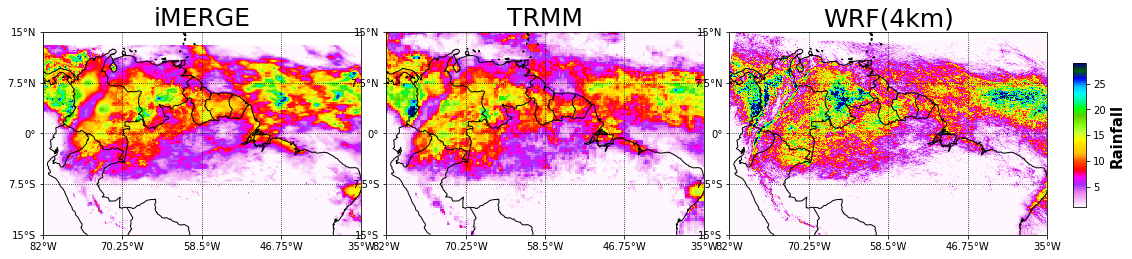

In [14]:
crs = ccrs.PlateCarree()
#crs = ccrs.Mollweide()
fig,ax = plt.subplots(ncols=nplots,figsize=[xfsize, 10],subplot_kw={'projection': crs})


lon = prc_mean.lon
lat = prc_mean.lat



### PLOT LOOP ###

for ii in range(0,nplots): 

    print(ii)

    if not cam_only:
        if ii==1: # Obs.
            plotx = ax[ii].pcolormesh(prec_obs.lon,prec_obs.lat,prec_obs_mean,cmap="gist_ncar_r",vmin=min(levels),vmax=max(levels))
#            plotx = ax[ii].pcolormesh(prec_obs.lon,prec_obs.time,prec_obs_mean,cmap="gist_ncar_r",vmin=min(levels),vmax=max(levels))
        if ii==0: # Obs.
            plotx = ax[ii].pcolormesh(prec_obs2.lon,prec_obs2.lat,prec_obs2_mean,cmap="gist_ncar_r",vmin=min(levels),vmax=max(levels))
#            plotx = ax[ii].pcolormesh(prec_obs2.lon,prec_obs2.time,prec_obs2_mean,cmap="gist_ncar_r",vmin=min(levels),vmax=max(levels))
        if ii==2: # WRF
            plotx = ax[ii].pcolormesh(lon, lat, prc_mean, cmap="gist_ncar_r",vmin=min(levels),vmax=max(levels))
        if ii==3: # SE
            plotx = ax[ii].tricontourf(clon_sam,clat_sam,cam_prc_mean_sam, levels=levels,cmap="gist_ncar_r")
 
    if cam_only: # SE
        
        #### CAM ####
        
        ds_cam = xr.open_dataset(dir_cam+file_cam[ii]).squeeze('time')
        print(ds_cam)
    
        prect_cam = ds_cam['PRECC'] + ds_cam['PRECL']


      
        cam_prc_mean = 86400.*1000.*prect_cam
#        cam_prc_std = cam_prc.std('time')

# Need to samp because this is a global field

        clon = ds_cam.lon
        clat = ds_cam.lat

# Sample only the SAM points
        log_sam = (clon > clon_min) & (clon < clon_max) & (clat > lat_min) & (clat < lat_max)
        print(cam_prc_mean)
        id_sam = np.where(log_sam)

        clat_sam = clat[log_sam]
        clon_sam = clon[log_sam]-360.
        cam_prc_mean_sam = cam_prc_mean[id_sam]
    
# PLOT CAM#
        plotx = ax[ii].tricontourf(clon_sam,clat_sam,cam_prc_mean_sam, levels=levels,cmap="gist_ncar_r")
    
    
    
    
    
    
    # Mask and ridlines
    
    ax[ii].coastlines()   
    ax[ii].add_feature(cf.BORDERS)
    ax[ii].grid(color="black", linestyle="dotted")

    # x-axes
    
    ax[ii].set_xticks(np.linspace(lon_min, lon_max, 5), crs=crs)  
    ax[ii].set_xlim((lon_min,lon_max))
    lon_formatter = LongitudeFormatter()
    ax[ii].xaxis.set_major_formatter(lon_formatter)
    
    # y-axes
    
    ax[ii].set_yticks(np.linspace(lat_min, lat_max, 5), crs=crs)  
    ax[ii].set_ylim((lat_min,lat_max))
    lat_formatter = LatitudeFormatter()
    ax[ii].yaxis.set_major_formatter(lat_formatter)
    
    
    ax[ii].set_title(case[ii],fontsize=25)
    
    
cb_ax = fig.add_axes([0.92, 0.4, 0.01, 0.2]) # xmin,ymin,dx,dy (Location of Colorbar)
plt.colorbar(plotx, cax=cb_ax,orientation="vertical").set_label(label='Rainfall',size=15,weight='bold')

plt.subplots_adjust(wspace=0.08, hspace=0.05)


plt.show()

fig_dir = ""
fig.savefig('pywrf_test_'+pset+'.png', dpi=400, bbox_inches='tight') 